# 导入库


In [2]:
import pandas as pd
import requests
from datetime import datetime
from jsonpath import jsonpath


def get_zt_stock_rank(date: str = None) -> pd.DataFrame:
    """
    获取指定日期涨停股票行情

    Parameters
    ----------
    date : str
        指定日期，默认为当前日期 格式形如 ``'20220506'``

    Returns
    -------
    DataFrame
        指定日期涨停股票行情

    Fields
    ------
    ``['日期', '股票代码', '股票名称', '涨跌幅', '成交额', '封板资金', '流通市值', '最新价', '换手率','首次封板时间', '最后封板时间', '炸板次数', '连扳数', '所属行业']``
    """
    if date is None:
        date = datetime.today().strftime('%Y%m%d')
    params = (
        ('ut', '7eea3edcaed734bea9cbfc24409ed989'),
        ('dpt', 'wz.ztzt'),
        ('Pageindex', '0'),
        ('pagesize', '10000'),
        ('sort', 'fbt:asc'),
        ('date', date),
    )

    response = requests.get(
        'http://push2ex.eastmoney.com/getTopicZTPool', params=params,  verify=False)
    fields = {
        'c': '股票代码',
        'n': '股票名称',
        'zdp': '涨跌幅',
        'amount': '成交额',
        'fund': '封板资金',
        'ltsz': '流通市值',
        'p': '最新价',
        'hs': '换手率',
        'fbt': '首次封板时间',
        'lbt': '最后封板时间',
        'zbc': '炸板次数',
        'lbc': '连板数',
        'hybk': '所属行业'
    }
    items = jsonpath(response.json(), '$..pool[:]')
    if not items:
        df = pd.DataFrame(
            columns=['日期']+list(fields.values())+['统计天数', '涨停次数'])
        return df
    df = pd.DataFrame(items)
    extra_df: pd.DataFrame = pd.DataFrame.from_records(df['zttj']).rename(columns={
        'days': '统计天数',
        'ct': '涨停次数'
    })
    df: pd.DataFrame = pd.concat([df, extra_df], axis=1)
    df: pd.DataFrame = df.rename(columns=fields)[fields.values()]
    df['首次封板时间'] = df['首次封板时间'].apply(lambda x: pd.to_datetime(
        str(x), format='%H%M%S').strftime('%H:%M:%S'))
    df['最后封板时间'] = df['最后封板时间'].apply(lambda x: pd.to_datetime(
        str(x), format='%H%M%S').strftime('%H:%M:%S'))
    df['最新价'] /= 1000
    df['涨跌幅'] = df['涨跌幅'].apply(lambda x: round(x, 2))
    df.insert(0, '日期', date)

    # 修改列名，同同花顺数据
    col = {"涨跌幅":"涨跌幅"+date,"成交额":"成交额"+date,'封板资金':'封板资金'+date, '流通市值':'流通市值'+date, 
    '最新价':'最新价'+date, '换手率':'换手率'+date,'首次封板时间':'首次封板时间'+date, '最后封板时间':'最后封板时间'+date, '炸板次数':'炸板次数'+date, '连板数':'连板数'+date}

    df.rename(columns=col,inplace = True)
    return df

def grade(x,dt1,dt2):
    score = 0
    # if x['首次封板时间'] > x['最后封板时间']:
    #     score += 10
    # else:
    #     score -=10
    return score
dt1='20220523'
dt2 = '20220524' #datetime.today().strftime('%Y%m%d')

df1 = get_zt_stock_rank(dt1)
df2 = get_zt_stock_rank(dt2)

df3= pd.merge(df1,df2,on='股票代码',how='left')

df3['封板评分'+dt2]=df3.apply(lambda x:grade(x,dt1,dt2),axis=1)
# df4=df3.loc[('首次封板时间'+dt2)]

# 昨日涨停，今日连板
df3.dropna(inplace=True)
# df3=df3[df3['封板资金20220523'].notnull()]
# df3

# 昨日涨停，今日断板
df3= pd.merge(df1,df2,on='股票代码',how='left')
# df3=df3[df3['封板资金20220523'].isnull()]
# # 昨日连板3板以上，今日断板
# df3.loc[df3['连板数'+dt1] > 3]


# 哪些股票今日2进3，3进4等：where 今日连板=3 昨日连板10个，成功晋级4个，那数据在2->3 显示4/10
# 昨日2板，今日3板；
def up(x,dt1,dt2):
    if pd.isna(x['连板数'+dt2]):
        return '止步于:'+ str(x['连板数'+dt1]) +'板'
    else:
        return '晋级成功:'+str(x['连板数'+dt1])+'进'+str(x['连板数'+dt2])

df3.loc[:,'晋级']=df3.apply(lambda x:up(x,dt1,dt2),axis=1)
# df3.to_csv('20220524.csv',encoding='utf_8_sig')
# 首版晋级成功率
def compr(a,b,df,dt1,dt2):
    x = str(df.loc[(df['连板数'+dt1]==a)].count()['连板数'+dt1])
    y = str(df.loc[(df['连板数'+dt2]==b)].count()['连板数'+dt2])
    return y+'/'+x

i=1
while i<10:
    print('连板晋级成功率：'+str(i)+'进'+str(i+1)+':'+compr(i,i+1,df3,dt1,dt2))
    i +=1

df5int=df1.loc[(df1.日期==dt1)&(df1.股票名称=='上海亚虹')]['炸板次数'+dt1]
print(int(df5int))
# cat_count_series=df1['所属行业'].drop_duplicates()
# 实现 where in 用法 
cat_count_series=['专用设备','有色金属']
# df1.loc[(df1.所属行业.isin(cat_count_series))]

# 实现 where not in 用法 
# df1.loc[(-df1.所属行业.isin(cat_count_series))]

# df2.loc[(df2['连板数'+dt2]==1)].to_csv('20220525.csv',encoding='utf_8_sig')
df3



连板晋级成功率：1进2:9/71
连板晋级成功率：2进3:3/14
连板晋级成功率：3进4:3/5
连板晋级成功率：4进5:1/1
连板晋级成功率：5进6:0/2
连板晋级成功率：6进7:0/0
连板晋级成功率：7进8:1/1
连板晋级成功率：8进9:1/2
连板晋级成功率：9进10:0/0
3


,日期_x,股票代码,股票名称_x,涨跌幅20220523,成交额20220523,封板资金20220523,流通市值20220523,最新价20220523,换手率20220523,首次封板时间20220523,...,封板资金20220524,流通市值20220524,最新价20220524,换手率20220524,首次封板时间20220524,最后封板时间20220524,炸板次数20220524,连板数20220524,所属行业_y,晋级
0,20220523,603097,江苏华辰,10.01,17582964,244906640,9.580000e+08,23.95,1.835382,09:25:00,...,107085372.0,1.054000e+09,26.35,35.005093,09:25:03,09:25:03,0.0,9.0,电网设备,晋级成功:8进9.0
1,20220523,000753,漳州发展,10.09,51072180,170530358,4.868172e+09,4.91,1.049104,09:25:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,止步于:3板
2,20220523,002578,闽发铝业,10.04,60617801,82094360,4.367397e+09,4.93,1.387962,09:25:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,止步于:2板
3,20220523,002449,国星光电,10.00,24665461,128123174,5.187370e+09,8.47,0.475491,09:25:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,止步于:2板
4,20220523,001318,阳光乳业,9.99,6240203,215342458,1.059086e+09,14.98,0.589207,09:25:00,...,210904365.0,1.165136e+09,16.48,1.398451,09:25:00,09:25:00,0.0,3.0,食品饮料,晋级成功:2进3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,20220523,603040,新坐标,9.97,74032116,5735010,2.319351e+09,17.31,3.306558,14:16:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,止步于:1板
92,20220523,603665,康隆达,10.00,101996431,9283602,7.137542e+09,44.42,1.478313,14:24:03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,止步于:1板
93,20220523,300550,和仁科技,20.00,318845840,18410695,3.746924e+09,14.34,8.821255,14:32:27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,止步于:1板
94,20220523,002416,爱施德,10.00,249016586,23137305,1.156679e+10,9.46,2.206044,14:42:57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,止步于:1板


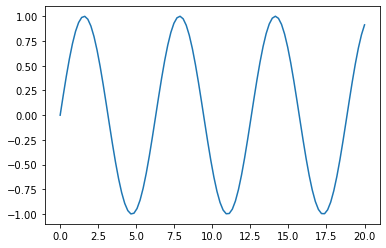

In [3]:
import matplotlib.pyplot as plt 
import numpy as np

x = np.linspace(0,20,100) #Create a list of evenly-spaced numbers over the range 
plt.plot(x,np.sin(x))
#Plot the sine of each x point
plt.show()
#Display the plot


# 使用例子


In [8]:
import pandas as pd
import numpy as np

df6 = pd.DataFrame(np.arange(36).reshape(6, 6), index=list('abcdef'), columns=list('ABCDEF'))
print(df6)

dfff = pd.DataFrame(np.arange(6).reshape(1, 6),columns=list('ABCDEF'))
print(dfff)

dfx = pd.concat([df6,dfff])
dfx.T

    A   B   C   D   E   F
a   0   1   2   3   4   5
b   6   7   8   9  10  11
c  12  13  14  15  16  17
d  18  19  20  21  22  23
e  24  25  26  27  28  29
f  30  31  32  33  34  35
   A  B  C  D  E  F
0  0  1  2  3  4  5


,a,b,c,d,e,f,0
A,0,6,12,18,24,30,0
B,1,7,13,19,25,31,1
C,2,8,14,20,26,32,2
D,3,9,15,21,27,33,3
E,4,10,16,22,28,34,4
F,5,11,17,23,29,35,5


### 获取单只股票基本信息


In [34]:
import efinance as ef
stock_code = '600519'
ef.stock.get_base_info(stock_code)


股票代码               600519
股票名称                 贵州茅台
市盈率(动)              32.43
市净率                 10.82
所处行业                 酿酒行业
总市值       2237288281800.0
流通市值      2237288281800.0
板块编号               BK0477
ROE                   8.7
净利率             55.586597
净利润        17244968587.32
毛利率             92.367676
dtype: object

### 获取多只股票基本信息


In [3]:
stock_codes = ['600519','300750']
ef.stock.get_base_info(stock_codes)

Processing => 300750: 100%|██████████| 2/2 [00:00<00:00, 32.87it/s]

,股票代码,股票名称,市盈率(动),市净率,所处行业,总市值,流通市值,板块编号,ROE,净利率,净利润,毛利率
0,600519,贵州茅台,40.31,12.29,酿酒行业,1.987719e+12,1.987719e+12,BK0477,14.20,53.387935,2.465399e+10,91.378421
1,300750,宁德时代,130.90,17.07,汽车行业,1.173867e+12,1.023030e+12,BK0481,6.74,12.082045,4.483788e+09,27.255689


### 获取单只股票日 k 数据


In [4]:

beg = '20200101' # 开始日期
end = '20210101'   # 结束日期
ef.stock.get_quote_history(stock_code,beg== beg,end=end)

,股票名称,股票代码,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,贵州茅台,600519,2001-08-27,-89.74,-89.53,-89.08,-90.07,406318,1.410347e+09,-1.10,0.92,0.83,56.83
1,贵州茅台,600519,2001-08-28,-89.64,-89.27,-89.24,-89.72,129647,4.634630e+08,-0.54,0.29,0.26,18.13
2,贵州茅台,600519,2001-08-29,-89.24,-89.36,-89.24,-89.42,53252,1.946890e+08,-0.20,-0.10,-0.09,7.45
3,贵州茅台,600519,2001-08-30,-89.38,-89.22,-89.14,-89.44,48013,1.775580e+08,-0.34,0.16,0.14,6.72
4,贵州茅台,600519,2001-08-31,-89.21,-89.24,-89.12,-89.28,23231,8.623100e+07,-0.18,-0.02,-0.02,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617,贵州茅台,600519,2020-12-25,1783.70,1810.71,1827.71,1780.71,23088,4.218998e+09,2.60,-0.02,-0.34,0.18
4618,贵州茅台,600519,2020-12-28,1807.31,1853.71,1869.51,1806.76,30080,5.616529e+09,3.47,2.37,43.00,0.24
4619,贵州茅台,600519,2020-12-29,1853.71,1847.71,1867.51,1835.71,22868,4.275995e+09,1.72,-0.32,-6.00,0.18
4620,贵州茅台,600519,2020-12-30,1850.71,1913.71,1913.71,1850.70,34452,6.604461e+09,3.41,3.57,66.00,0.27


#### 获取单只股票的 5 分钟 k 线数据


In [5]:
import efinance as ef
stock_code = '600519'
beg = '20200101' # 开始日期
end = '20500101'   # 结束日期(最好比当前日期大，要不然可能没有数据)
klt = 5 # 指定获取的 k 线数据是 5 分钟的
ef.stock.get_quote_history(stock_code,beg = beg,end = end,klt=5)


,股票名称,股票代码,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,贵州茅台,600519,2021-07-16 09:35,1980.00,1986.99,1996.60,1980.00,2221,441525957.0,0.83,-0.55,-11.00,0.02
1,贵州茅台,600519,2021-07-16 09:40,1986.66,1972.00,1986.66,1972.00,2084,412387747.0,0.74,-0.75,-14.99,0.02
2,贵州茅台,600519,2021-07-16 09:45,1973.00,1977.66,1979.00,1970.00,1258,248031161.0,0.46,0.29,5.66,0.01
3,贵州茅台,600519,2021-07-16 09:50,1977.66,1977.85,1978.00,1972.16,561,110835110.0,0.30,0.01,0.19,0.00
4,贵州茅台,600519,2021-07-16 09:55,1977.90,1972.01,1982.70,1972.00,992,196066622.0,0.54,-0.30,-5.84,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,贵州茅台,600519,2021-08-30 13:55,1591.00,1590.00,1593.99,1588.34,552,87810423.0,0.36,-0.06,-1.01,0.00
1523,贵州茅台,600519,2021-08-30 14:00,1590.15,1582.06,1590.22,1582.06,461,73220772.0,0.51,-0.50,-7.94,0.00
1524,贵州茅台,600519,2021-08-30 14:05,1582.02,1585.05,1588.28,1580.03,437,69234613.0,0.52,0.19,2.99,0.00
1525,贵州茅台,600519,2021-08-30 14:10,1583.60,1584.00,1585.10,1581.69,443,70119399.0,0.22,-0.07,-1.05,0.00


### 获取多只股票日 k 数据(得到以股票代码为 key，以 pandas.DataFrame 为值的字典)


In [6]:

beg = '20200101' # 开始日期
end = '20210101'   # 结束日期
stock_codes = ['600519','300750']
df_items = ef.stock.get_quote_history(stock_codes,beg== beg,end=end)

Processing => 600519: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


In [7]:
type(df_items) # 查看类型

dict

In [8]:
df_items.keys()

dict_keys(['300750', '600519'])

In [4]:
df_items[stock_codes[0]] # 查看第一支股票的的 k 线数据

NameError: name 'df_items' is not defined

### 沪深市场股票最新季度业绩表现


In [10]:
import efinance as ef
ef.stock.get_all_company_performance()

,股票代码,股票简称,公告日期,营业收入,营业收入同比增长,营业收入季度环比,净利润,净利润同比增长,净利润季度环比,每股收益,每股净资产,净资产收益率,销售毛利率,每股经营现金流量
0,688799,华纳药厂,2021-08-30 00:00:00,5.194802e+08,34.227814,19.0525,6.916667e+07,21.600000,6.6067,0.9800,10.415597,9.91,72.160098,0.374232
1,688697,纽威数控,2021-08-30 00:00:00,7.986240e+08,47.656165,NaN,6.902427e+07,26.170000,NaN,0.2800,2.329215,12.91,24.068031,0.242221
2,688618,三旺通信,2021-08-30 00:00:00,1.054643e+08,23.672318,71.7003,2.520688e+07,-13.170000,236.6923,0.5000,13.413387,3.70,61.486354,0.163731
3,688567,孚能科技,2021-08-30 00:00:00,8.770511e+08,207.256121,39.1811,-2.263626e+08,-29.322674,71.5266,-0.2100,9.212178,-2.27,5.277056,-0.187251
4,688518,联赢激光,2021-08-30 00:00:00,5.243876e+08,73.146549,29.8116,2.444206e+07,121.350000,-8.5724,0.0800,4.782286,1.68,36.603566,0.220454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006,600131,国网信通,2021-07-16 00:00:00,2.880378e+09,6.787087,69.5794,2.171389e+08,29.570000,296.2051,0.1800,4.063260,4.57,19.137437,-0.798689
4007,600644,乐山电力,2021-07-15 00:00:00,1.257030e+09,18.079648,5.7300,8.379727e+07,-14.300000,25.0007,0.1556,3.112413,5.13,23.645137,0.200906
4008,002261,拓维信息,2021-07-15 00:00:00,8.901777e+08,47.505282,24.0732,6.071063e+07,68.320000,30.0596,0.0550,2.351598,2.37,37.047968,-0.131873
4009,601952,苏垦农发,2021-07-13 00:00:00,4.544138e+09,11.754570,47.8758,3.288132e+08,1.460000,83.1486,0.2400,3.888046,6.05,15.491684,-0.173772


### 沪深市场股票指定日期的季度业绩表现


In [11]:
import efinance as ef
ef.stock.get_all_company_performance(date='2021-03-31')

,股票代码,股票简称,公告日期,营业收入,营业收入同比增长,营业收入季度环比,净利润,净利润同比增长,净利润季度环比,每股收益,每股净资产,净资产收益率,销售毛利率,每股经营现金流量
0,605033,美邦股份,2021-08-25 00:00:00,2.745798e+08,26.057649,NaN,4.657619e+07,7.819901,NaN,0.4600,4.890950,9.85,35.727826,-1.247530
1,688728,格科微,2021-07-30 00:00:00,1.937567e+09,55.296902,7.2463,2.921972e+08,48.691336,96.9490,0.1300,1.126685,10.18,31.272208,0.139490
2,301048,金鹰重工,2021-07-30 00:00:00,6.626118e+08,622.939051,NaN,6.502268e+07,396.908689,NaN,0.1600,3.523889,4.72,17.725787,-0.206652
3,301047,义翘神州,2021-07-30 00:00:00,4.565855e+08,311.160945,-13.4857,3.322075e+08,417.919173,-11.8844,6.5100,31.975995,22.67,96.830697,4.746849
4,688733,壹石通,2021-07-29 00:00:00,7.290342e+07,NaN,NaN,1.748394e+07,NaN,NaN,0.1300,3.679212,3.54,42.588543,-0.166675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441,000928,中钢国际,2021-04-09 00:00:00,2.772485e+09,35.850545,-51.5781,1.226377e+08,1290.850000,-59.7903,0.0976,4.583237,2.15,11.679059,-1.717067
4442,000790,华神科技,2021-04-09 00:00:00,1.485114e+08,14.920461,-34.0759,1.171571e+07,82.760000,75.9991,0.0200,1.498744,1.28,62.801991,-0.093348
4443,300584,海辰药业,2021-04-08 00:00:00,1.622036e+08,-2.389353,2.4390,1.350987e+07,-21.300000,96.0872,0.1126,5.775312,1.97,81.107504,0.151283
4444,002825,纳尔股份,2021-04-08 00:00:00,3.674302e+08,73.198082,-7.1282,2.137438e+07,156.970000,81.8976,0.1300,6.304156,2.18,21.044165,0.077641


### 股票最新交易日单子流入情况(分钟级)


In [12]:
import efinance as ef
ef.stock.get_today_bill('600519')

,股票名称,股票代码,时间,主力净流入,小单净流入,中单净流入,大单净流入,超大单净流入
0,贵州茅台,600519,2021-08-30 09:31,-1668134.0,-30415.0,1698549.0,-5507909.0,3839775.0
1,贵州茅台,600519,2021-08-30 09:32,-9337263.0,-30415.0,9367678.0,-7110139.0,-2227124.0
2,贵州茅台,600519,2021-08-30 09:33,-26063866.0,-30415.0,26094280.0,-8726399.0,-17337467.0
3,贵州茅台,600519,2021-08-30 09:34,-33344105.0,29542.0,33314562.0,-9031126.0,-24312979.0
4,贵州茅台,600519,2021-08-30 09:35,-47656330.0,29542.0,47626786.0,-12164324.0,-35492006.0
...,...,...,...,...,...,...,...,...
186,贵州茅台,600519,2021-08-30 14:07,-348644498.0,901548.0,347742941.0,-16961910.0,-331682588.0
187,贵州茅台,600519,2021-08-30 14:08,-350226380.0,901548.0,349324823.0,-15379168.0,-334847212.0
188,贵州茅台,600519,2021-08-30 14:09,-349116980.0,901548.0,348215423.0,-11580274.0,-337536706.0
189,贵州茅台,600519,2021-08-30 14:10,-350697794.0,901548.0,349796237.0,-10155113.0,-340542681.0


### 股票历史交易日单子流入情况(日级)


In [13]:
import efinance as ef
ef.stock.get_history_bill('600519')

,股票名称,股票代码,日期,主力净流入,小单净流入,中单净流入,大单净流入,超大单净流入,主力净流入占比,小单流入净占比,中单流入净占比,大单流入净占比,超大单流入净占比,收盘价,涨跌幅
0,贵州茅台,600519,2021-04-02,22415648.0,-1399994.0,-21015746.0,-1.602662e+09,1.625078e+09,0.20,-0.01,-0.19,-14.59,14.80,2142.71,5.80
1,贵州茅台,600519,2021-04-06,-5732496.0,-950673.0,6683160.0,6.970202e+07,-7.543451e+07,-0.08,-0.01,0.10,1.00,-1.08,2106.74,-1.68
2,贵州茅台,600519,2021-04-07,-41035248.0,1495507.0,39539649.0,6.026660e+08,-6.437012e+08,-0.49,0.02,0.48,7.25,-7.74,2041.71,-3.09
3,贵州茅台,600519,2021-04-08,-12959200.0,-1917587.0,14876795.0,-4.111168e+08,3.981576e+08,-0.22,-0.03,0.25,-6.98,6.76,2050.71,0.44
4,贵州茅台,600519,2021-04-09,-19368960.0,422017.0,18946942.0,5.963018e+08,-6.156708e+08,-0.33,0.01,0.32,10.22,-10.56,2000.71,-2.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,贵州茅台,600519,2021-08-23,295886672.0,-4812064.0,-291074592.0,8.685579e+07,2.090309e+08,2.64,-0.04,-2.59,0.77,1.86,1570.19,1.43
97,贵州茅台,600519,2021-08-24,518892080.0,-9811615.0,-509080464.0,1.116964e+08,4.071956e+08,4.43,-0.08,-4.35,0.95,3.48,1625.18,3.50
98,贵州茅台,600519,2021-08-25,70324384.0,-1277551.0,-69046848.0,-2.118487e+08,2.821731e+08,0.78,-0.01,-0.76,-2.34,3.12,1665.02,2.45
99,贵州茅台,600519,2021-08-26,-669216880.0,-2813337.0,672030224.0,-1.682641e+08,-5.009528e+08,-7.67,-0.03,7.70,-1.93,-5.74,1595.00,-4.21


### 股票最新龙虎榜


In [14]:
ef.stock.get_daily_billboard()

,股票代码,股票名称,上榜日期,解读,收盘价,涨跌幅,换手率,龙虎榜净买额,龙虎榜买入额,龙虎榜卖出额,龙虎榜成交额,市场总成交额,净买额占总成交比,成交额占总成交比,流通市值,上榜原因
0,000608,阳光股份,2021-08-27,卖一主卖，成功率48.36%,3.73,-9.9034,3.8430,-8.709942e+06,1.422786e+07,2.293780e+07,3.716565e+07,110838793,-7.858208,33.531268,2.796761e+09,日跌幅偏离值达到7%的前5只证券
1,000751,锌业股份,2021-08-27,主力做T，成功率18.84%,5.32,-2.9197,19.6505,-1.079219e+08,5.638899e+07,1.643109e+08,2.206999e+08,1462953973,-7.376984,15.085906,7.500502e+09,日振幅值达到15%的前5只证券
2,000762,西藏矿业,2021-08-27,北京资金买入，成功率39.42%,63.99,1.0741,15.6463,2.938758e+07,4.675541e+08,4.381665e+08,9.057206e+08,4959962598,0.592496,18.260633,3.332571e+10,日振幅值达到15%的前5只证券
3,000833,粤桂股份,2021-08-27,实力游资买入，成功率44.55%,8.87,10.0496,8.8263,4.993555e+07,1.292967e+08,7.936120e+07,2.086580e+08,895910429,5.573721,23.290046,3.353614e+09,连续三个交易日内，涨幅偏离值累计达到20%的证券
4,001208,华菱线缆,2021-08-27,1家机构买入，成功率40.43%,19.72,4.3386,46.1985,4.055258e+07,1.537821e+08,1.132295e+08,2.670117e+08,1203913048,3.368398,22.178651,2.634710e+09,日换手率达到20%的前5只证券
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,688558,国盛智科,2021-08-27,买一主买，成功率38.71%,60.72,1.6064,34.0104,1.835494e+07,1.057779e+08,8.742293e+07,1.932008e+08,802569300,2.287023,24.072789,2.321743e+09,有价格涨跌幅限制的日换手率达到30%的前五只证券
71,688596,正帆科技,2021-08-27,1家机构买入，成功率57.67%,26.72,3.1660,3.9065,-1.371039e+07,8.409046e+07,9.780085e+07,1.818913e+08,745137400,-1.839982,24.410438,4.630550e+09,有价格涨跌幅限制的连续3个交易日内收盘价格涨幅偏离值累计达到30%的证券
72,688663,新风光,2021-08-27,卖一主卖，成功率37.18%,28.17,-17.6316,32.2409,1.036460e+07,5.416901e+07,4.380440e+07,9.797341e+07,274732700,3.772613,35.661358,8.492507e+08,有价格涨跌幅限制的日收盘价格跌幅达到15%的前五只证券
73,688663,新风光,2021-08-27,卖一主卖，成功率37.18%,28.17,-17.6316,32.2409,1.036460e+07,5.416901e+07,4.380440e+07,9.797341e+07,274732700,3.772613,35.661358,8.492507e+08,有价格涨跌幅限制的日换手率达到30%的前五只证券


### 指定日期区间的股票龙虎榜


In [15]:
# 开始日期
start_date = '2021-08-20'
# 结束日期
end_date = '2021-08-27'
ef.stock.get_daily_billboard(start_date=start_date,
                             end_date=end_date)


,股票代码,股票名称,上榜日期,解读,收盘价,涨跌幅,换手率,龙虎榜净买额,龙虎榜买入额,龙虎榜卖出额,龙虎榜成交额,市场总成交额,净买额占总成交比,成交额占总成交比,流通市值,上榜原因
0,000608,阳光股份,2021-08-27,卖一主卖，成功率48.36%,3.73,-9.9034,3.8430,-8.709942e+06,1.422786e+07,2.293780e+07,3.716565e+07,110838793,-7.858208,33.531268,2.796761e+09,日跌幅偏离值达到7%的前5只证券
1,000751,锌业股份,2021-08-27,主力做T，成功率18.84%,5.32,-2.9197,19.6505,-1.079219e+08,5.638899e+07,1.643109e+08,2.206999e+08,1462953973,-7.376984,15.085906,7.500502e+09,日振幅值达到15%的前5只证券
2,000762,西藏矿业,2021-08-27,北京资金买入，成功率39.42%,63.99,1.0741,15.6463,2.938758e+07,4.675541e+08,4.381665e+08,9.057206e+08,4959962598,0.592496,18.260633,3.332571e+10,日振幅值达到15%的前5只证券
3,000833,粤桂股份,2021-08-27,实力游资买入，成功率44.55%,8.87,10.0496,8.8263,4.993555e+07,1.292967e+08,7.936120e+07,2.086580e+08,895910429,5.573721,23.290046,3.353614e+09,连续三个交易日内，涨幅偏离值累计达到20%的证券
4,001208,华菱线缆,2021-08-27,1家机构买入，成功率40.43%,19.72,4.3386,46.1985,4.055258e+07,1.537821e+08,1.132295e+08,2.670117e+08,1203913048,3.368398,22.178651,2.634710e+09,日换手率达到20%的前5只证券
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,605580,恒盛能源,2021-08-20,买一主买，成功率33.33%,13.28,10.0249,0.4086,2.413149e+06,2.713051e+06,2.999022e+05,3.012953e+06,2713051,88.945937,111.054054,6.640000e+08,有价格涨跌幅限制的日收盘价格涨幅偏离值达到7%的前三只证券
415,688029,南微医学,2021-08-20,4家机构卖出，成功率55.82%,204.61,-18.5340,8.1809,-1.412053e+08,1.883342e+08,3.295394e+08,5.178736e+08,762045800,-18.529760,67.958326,9.001510e+09,有价格涨跌幅限制的日收盘价格跌幅达到15%的前五只证券
416,688408,中信博,2021-08-20,4家机构卖出，成功率47.86%,179.98,-0.0666,15.3723,-4.336304e+07,3.750919e+08,4.184550e+08,7.935469e+08,846547400,-5.122340,93.739221,5.695886e+09,有价格涨跌幅限制的日价格振幅达到30%的前五只证券
417,688556,高测股份,2021-08-20,上海资金买入，成功率60.21%,51.97,17.0495,10.6452,-3.940045e+07,1.642095e+08,2.036099e+08,3.678194e+08,575411600,-6.847351,63.922831,5.739089e+09,有价格涨跌幅限制的日收盘价格涨幅达到15%的前五只证券


### 股东数目


In [16]:
ef.stock.get_latest_holder_number()

,股票代码,股票名称,股东人数,股东人数增减,较上期变化百分比,股东户数统计截止日,户均持股市值,户均持股数量,总市值,总股本,公告日期
0,688618,三旺通信,4975,-7.200149,-386.0,2021-06-30 00:00:00,4.338763e+05,10156.280402,2.158535e+09,50527495,2021-08-30 00:00:00
1,688567,孚能科技,17810,7.860950,1298.0,2021-06-30 00:00:00,2.060182e+06,60116.209152,3.669185e+10,1070669685,2021-08-30 00:00:00
2,688518,联赢激光,13868,-10.419224,-1613.0,2021-06-30 00:00:00,4.049599e+05,21574.848572,5.615984e+09,299200000,2021-08-30 00:00:00
3,688388,嘉元科技,11158,44.216104,3421.0,2021-06-30 00:00:00,1.882101e+06,20691.521778,2.100048e+10,230876000,2021-08-30 00:00:00
4,688321,微芯生物,23855,11.780142,2514.0,2021-06-30 00:00:00,7.952706e+05,17217.375812,1.897118e+10,410720500,2021-08-30 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
401,600618,氯碱化工,45372,-0.756814,-346.0,2014-06-30 00:00:00,1.227918e+05,16526.491581,5.571311e+09,749839976,2014-08-22 00:00:00
402,601880,辽港股份,89923,-3.589540,-3348.0,2014-03-31 00:00:00,9.051553e+04,37403.111551,8.139428e+09,3363400000,2014-04-30 00:00:00
403,600685,中船防务,52296,-4.807325,-2641.0,2014-03-11 00:00:00,1.315491e+05,8384.263691,6.879492e+09,438463454,2014-03-18 00:00:00
404,000017,深中华A,21358,-10.800200,-2586.0,2013-06-30 00:00:00,5.943993e+04,14186.140556,1.269518e+09,302987590,2013-08-24 00:00:00


# 更多使用例子详见文档 [efinance-docs](https://efinance.readthedocs.io/)
